# Libraries

## I/O

In [1]:
import os
from pprint import pprint
from util_IO import (
    load_pickle_from_main_project_dir,
    load_attributes_df,
    get_stadiamaps_provider_api_key_in_env,
    geo_plot_basic
)

## Analysis

In [2]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

# Settings

## Packages

In [3]:
# Set pandas to display a maximum of 300 columns
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 1000)

In [4]:
%matplotlib inline

## Parameters

### Load metadata from previous step (*1-DataAggregation.ipynb*)

In [5]:
aggr_parameters_dict, camels_gb_use_case_dir = load_pickle_from_main_project_dir(
    'aggr_parameters_dict.pkl'
)

# # Print imported variable
pprint(aggr_parameters_dict)

{'attributes': {'aggregations': {'fundamental': {'climatic_attributes_df': [],
                                                 'humaninfluence_attributes_df': ['surfacewater_abs',
                                                                                  'groundwater_abs',
                                                                                  'discharges',
                                                                                  'num_reservoir',
                                                                                  'reservoir_cap'],
                                                 'hydrogeology_attributes_df': [],
                                                 'hydrologic_attributes_df': [],
                                                 'hydrometry_attributes_df': ['bankfull_flow'],
                                                 'landcover_attributes_df': ['dwood_perc',
                                                                        

### Retrieve variables in use

In [6]:
# Index field
attributes_index = aggr_parameters_dict["attributes"]["attributes_index"]
camels_gb_data_attributes_aggr_dir = aggr_parameters_dict['camels_gb_data_attributes_aggr_dir']
camels_gb_bronze_dir = aggr_parameters_dict['camels_gb_bronze_dir']

In [7]:
# Update the provider URL to include your API key
stadiamaps_provider = get_stadiamaps_provider_api_key_in_env()

# Attributes

## Retrieve aggregated tabular file

In [8]:
# Read the file into a DataFrame
attributes_df = load_attributes_df(
    camels_gb_data_attributes_aggr_dir,
    "fundamental.csv",
    attributes_index
)

display(attributes_df.head(3))

,sand_perc,silt_perc,clay_perc,organic_perc,gauge_name,gauge_lat,gauge_lon,gauge_elev,area,dpsbar,elev_mean,elev_min,elev_10,elev_50,elev_90,elev_max,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,surfacewater_abs,groundwater_abs,discharges,num_reservoir,reservoir_cap,bankfull_flow,@id,label,query_for_station_specifics,station_code
gauge_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101002,70.99,15.36,13.66,0.43,Medina at Shide,50.69,-1.29,10.4,30.61,80.0,60.0,9.4,26.8,56.8,98.0,193.2,6.20,0.30,42.78,0.38,46.34,3.28,0.49,0.56,0.006,0.023,0.018,0,0,17.8,http://environment.data.gov.uk/hydrology/id/st...,Shide,https://environment.data.gov.uk/hydrology/id/m...,69f4b3e5-a487-4769-aded-0d72062428e7
101005,71.01,15.56,13.45,0.45,Eastern Yar at Budbridge,50.65,-1.25,17.2,24.31,87.0,92.0,17.2,32.9,84.0,157.2,234.6,4.60,0.12,59.24,0.25,31.08,4.78,0.05,0.00,0.001,0.015,0.053,0,0,NaN,http://environment.data.gov.uk/hydrology/id/st...,Budbridge,https://environment.data.gov.uk/hydrology/id/m...,c10d61a3-fc5d-4d96-bf9f-57a97b6256c0
22001,45.16,31.88,22.96,4.13,Coquet at Morwick,55.33,-1.63,5.2,578.25,110.0,225.0,5.2,79.3,192.8,420.0,774.5,5.87,9.60,59.92,11.13,12.49,0.95,0.13,0.00,0.000,0.006,0.004,0,0,175.0,http://environment.data.gov.uk/hydrology/id/st...,Morwick,https://environment.data.gov.uk/hydrology/id/m...,3df7a9c3-d40c-4781-a885-5f6b7abdb86a


## Remove fields for better readability on maps

In [9]:
(
    attributes_df.
        drop(
            columns=[
                'station_code',
                'query_for_station_specifics',
                'label',
                '@id',
                'elev_10',
                'elev_50',
                'elev_90'
            ],
            inplace=True
        )
)

## Geographical data

### Retrieve catchments boundaries

In [10]:
# Load polygons
gdf_catchments = gpd.read_file(
    os.path.join(
        camels_gb_bronze_dir,
        'CAMELS_GB_catchment_boundaries',
        'CAMELS_GB_catchment_boundaries.shp'
    )
)

print(f"Total number of catchments:\t{gdf_catchments.shape[0]}")

Total number of catchments:	671


In [11]:
gdf_catchments.head(3)

,ID_STRING,ID,SOURCE,VERSION,EXPORTED,geometry
0,10002,10002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((410125 848525, 410075 848525, 410075..."
1,10003,10003.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((394725 830350, 394725 830300, 394650..."
2,1001,1001.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((326225 954900, 326225 954850, 326200..."


### Gauging stations

In [12]:
# Load gauging stations positions into GeoDataFrame object
gdf_stations = (
    gpd.GeoDataFrame(
        attributes_df,
        geometry=(
            gpd.points_from_xy(attributes_df['gauge_lon'], attributes_df['gauge_lat'])
        ),
        crs="EPSG:4326"
    )
)

gdf_stations = gdf_stations.to_crs(gdf_catchments.crs)

gdf_stations.head(3)

,sand_perc,silt_perc,clay_perc,organic_perc,gauge_name,gauge_lat,gauge_lon,gauge_elev,area,dpsbar,elev_mean,elev_min,elev_max,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,surfacewater_abs,groundwater_abs,discharges,num_reservoir,reservoir_cap,bankfull_flow,geometry
gauge_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101002,70.99,15.36,13.66,0.43,Medina at Shide,50.69,-1.29,10.4,30.61,80.0,60.0,9.4,193.2,6.20,0.30,42.78,0.38,46.34,3.28,0.49,0.56,0.006,0.023,0.018,0,0,17.8,POINT (450249.179 88056.879)
101005,71.01,15.56,13.45,0.45,Eastern Yar at Budbridge,50.65,-1.25,17.2,24.31,87.0,92.0,17.2,234.6,4.60,0.12,59.24,0.25,31.08,4.78,0.05,0.00,0.001,0.015,0.053,0,0,NaN,POINT (453119.685 83636.77)
22001,45.16,31.88,22.96,4.13,Coquet at Morwick,55.33,-1.63,5.2,578.25,110.0,225.0,5.2,774.5,5.87,9.60,59.92,11.13,12.49,0.95,0.13,0.00,0.000,0.006,0.004,0,0,175.0,POINT (423572.545 604055.981)


### Maps

#### Catchments (*in sample*)

In [13]:
gdf_catchments_in_sample = (
    gdf_catchments[
        gdf_catchments['ID_STRING'].isin(gdf_stations.index)
    ]
)

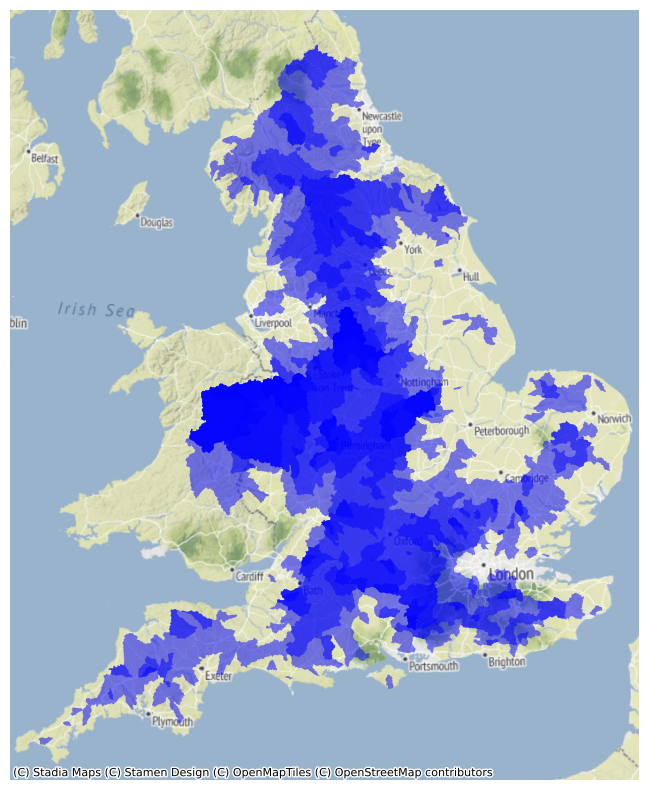

In [14]:
fig, ax = geo_plot_basic(
    gdf_catchments_in_sample,
    stadiamaps_provider
)
plt.show()

#### Stations

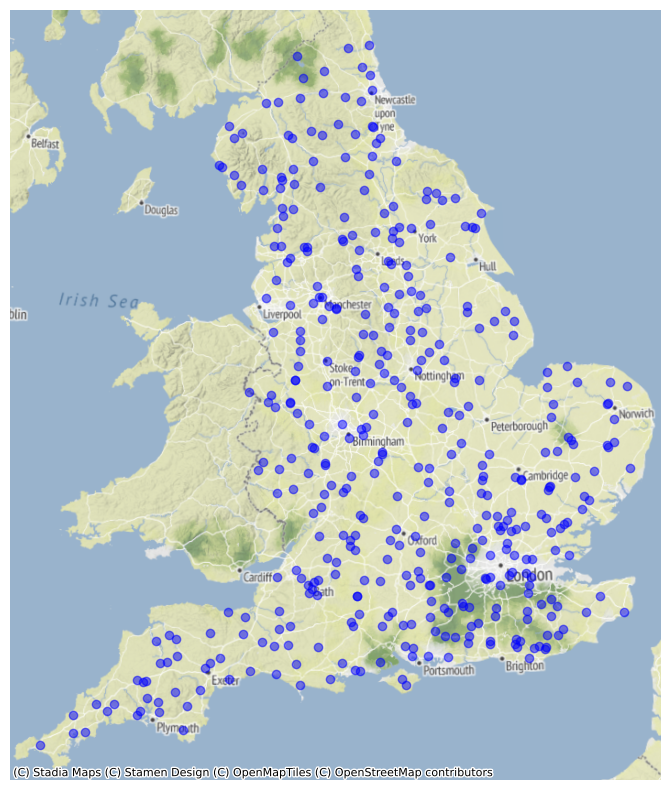

In [16]:
fig, ax = geo_plot_basic(
    gdf_stations,
    stadiamaps_provider
)
plt.show()

#### Catchments & Stations

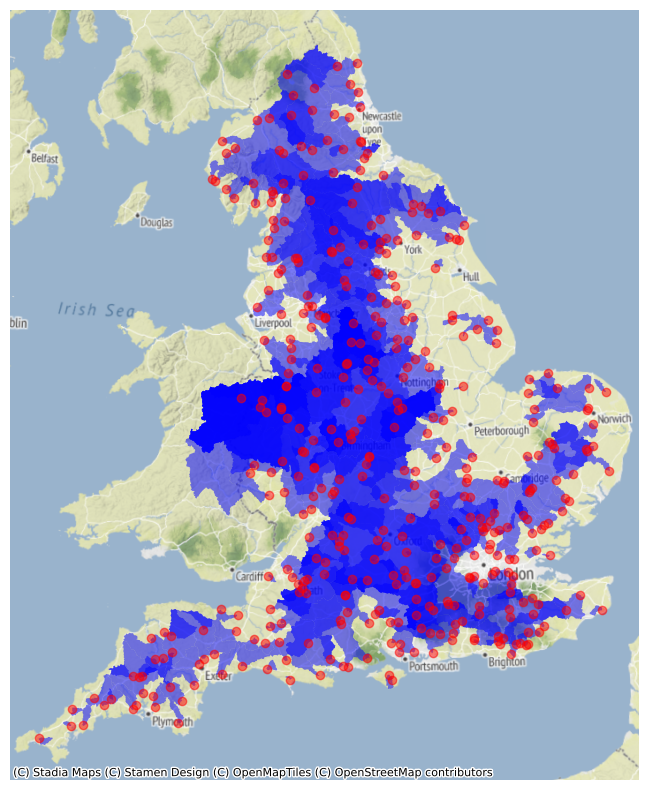

In [17]:
# Plot the first dataset
fig, ax = geo_plot_basic(
    gdf_catchments_in_sample,
    stadiamaps_provider
)

# Plot the second dataset on the same axis
gdf_stations.plot(ax=ax, alpha=0.5, color='red')

# Show the combined plot
plt.show()

#### Custom catchments list

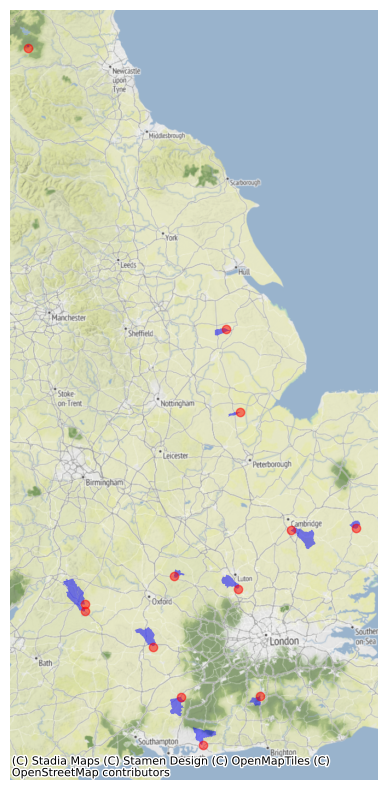

In [18]:
# Define custom catchments list
custom_areas_ids_list = [
    '39035',
    '29009',
    '39054',
    '33053',
    '39099',
    '36009',
    '39120',
    '30014',
    '39125',
    '39114',
    '39017',
    '76011',
    '41023'
]

fig, ax = geo_plot_basic(
    gdf_catchments_in_sample[
        gdf_catchments_in_sample['ID_STRING'].isin(custom_areas_ids_list)
    ],
    stadiamaps_provider
)
gdf_stations.loc[custom_areas_ids_list].plot(ax=ax, alpha=0.5, color='red')
plt.show()

### Areas checks

In [19]:
# Calculate the area in square meters
gdf_catchments_in_sample['area_sqm'] = gdf_catchments_in_sample['geometry'].area

# Convert the area to square kilometers
gdf_catchments_in_sample['area_sqkm'] = gdf_catchments_in_sample['area_sqm'] / 1e6

# Merge information with stations geo dataframe
area_check_df = (
    gdf_stations[['area', 'gauge_name']]
        .merge(
            gdf_catchments_in_sample[['ID_STRING', 'area_sqkm']],
            left_index=True,
            right_on='ID_STRING',
            how='left'
        )
)

area_check_df.set_index('ID_STRING', inplace=True)
area_check_df['area_perc_diff'] = (
    (area_check_df['area'] - area_check_df['area_sqkm']) 
        / area_check_df['area_sqkm']
)

area_check_df.describe()

/opt/conda/envs/geo/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/geo/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,area,area_sqkm,area_perc_diff
count,419.000000,419.000000,419.000000
mean,408.984320,408.984438,-0.000002
std,1070.369659,1070.370555,0.000090
min,1.630000,1.630000,-0.000586
25%,63.025000,63.021250,-0.000028
50%,137.810000,137.815000,0.000000
75%,314.405000,314.409375,0.000019
max,9930.800000,9930.829375,0.000579
